**Importing important Libraries**




In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import shutil


2025-07-22 03:48:39.446343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753156119.642864      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753156119.695824      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


**Set seeds for reproducibility**

In [4]:
import random
import numpy as np
import tensorflow as tf


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:

DATASET_PATH = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 120

# Preprocessing with Validation Split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())


Found 60800 images belonging to 38 classes.
Found 15200 images belonging to 38 classes.


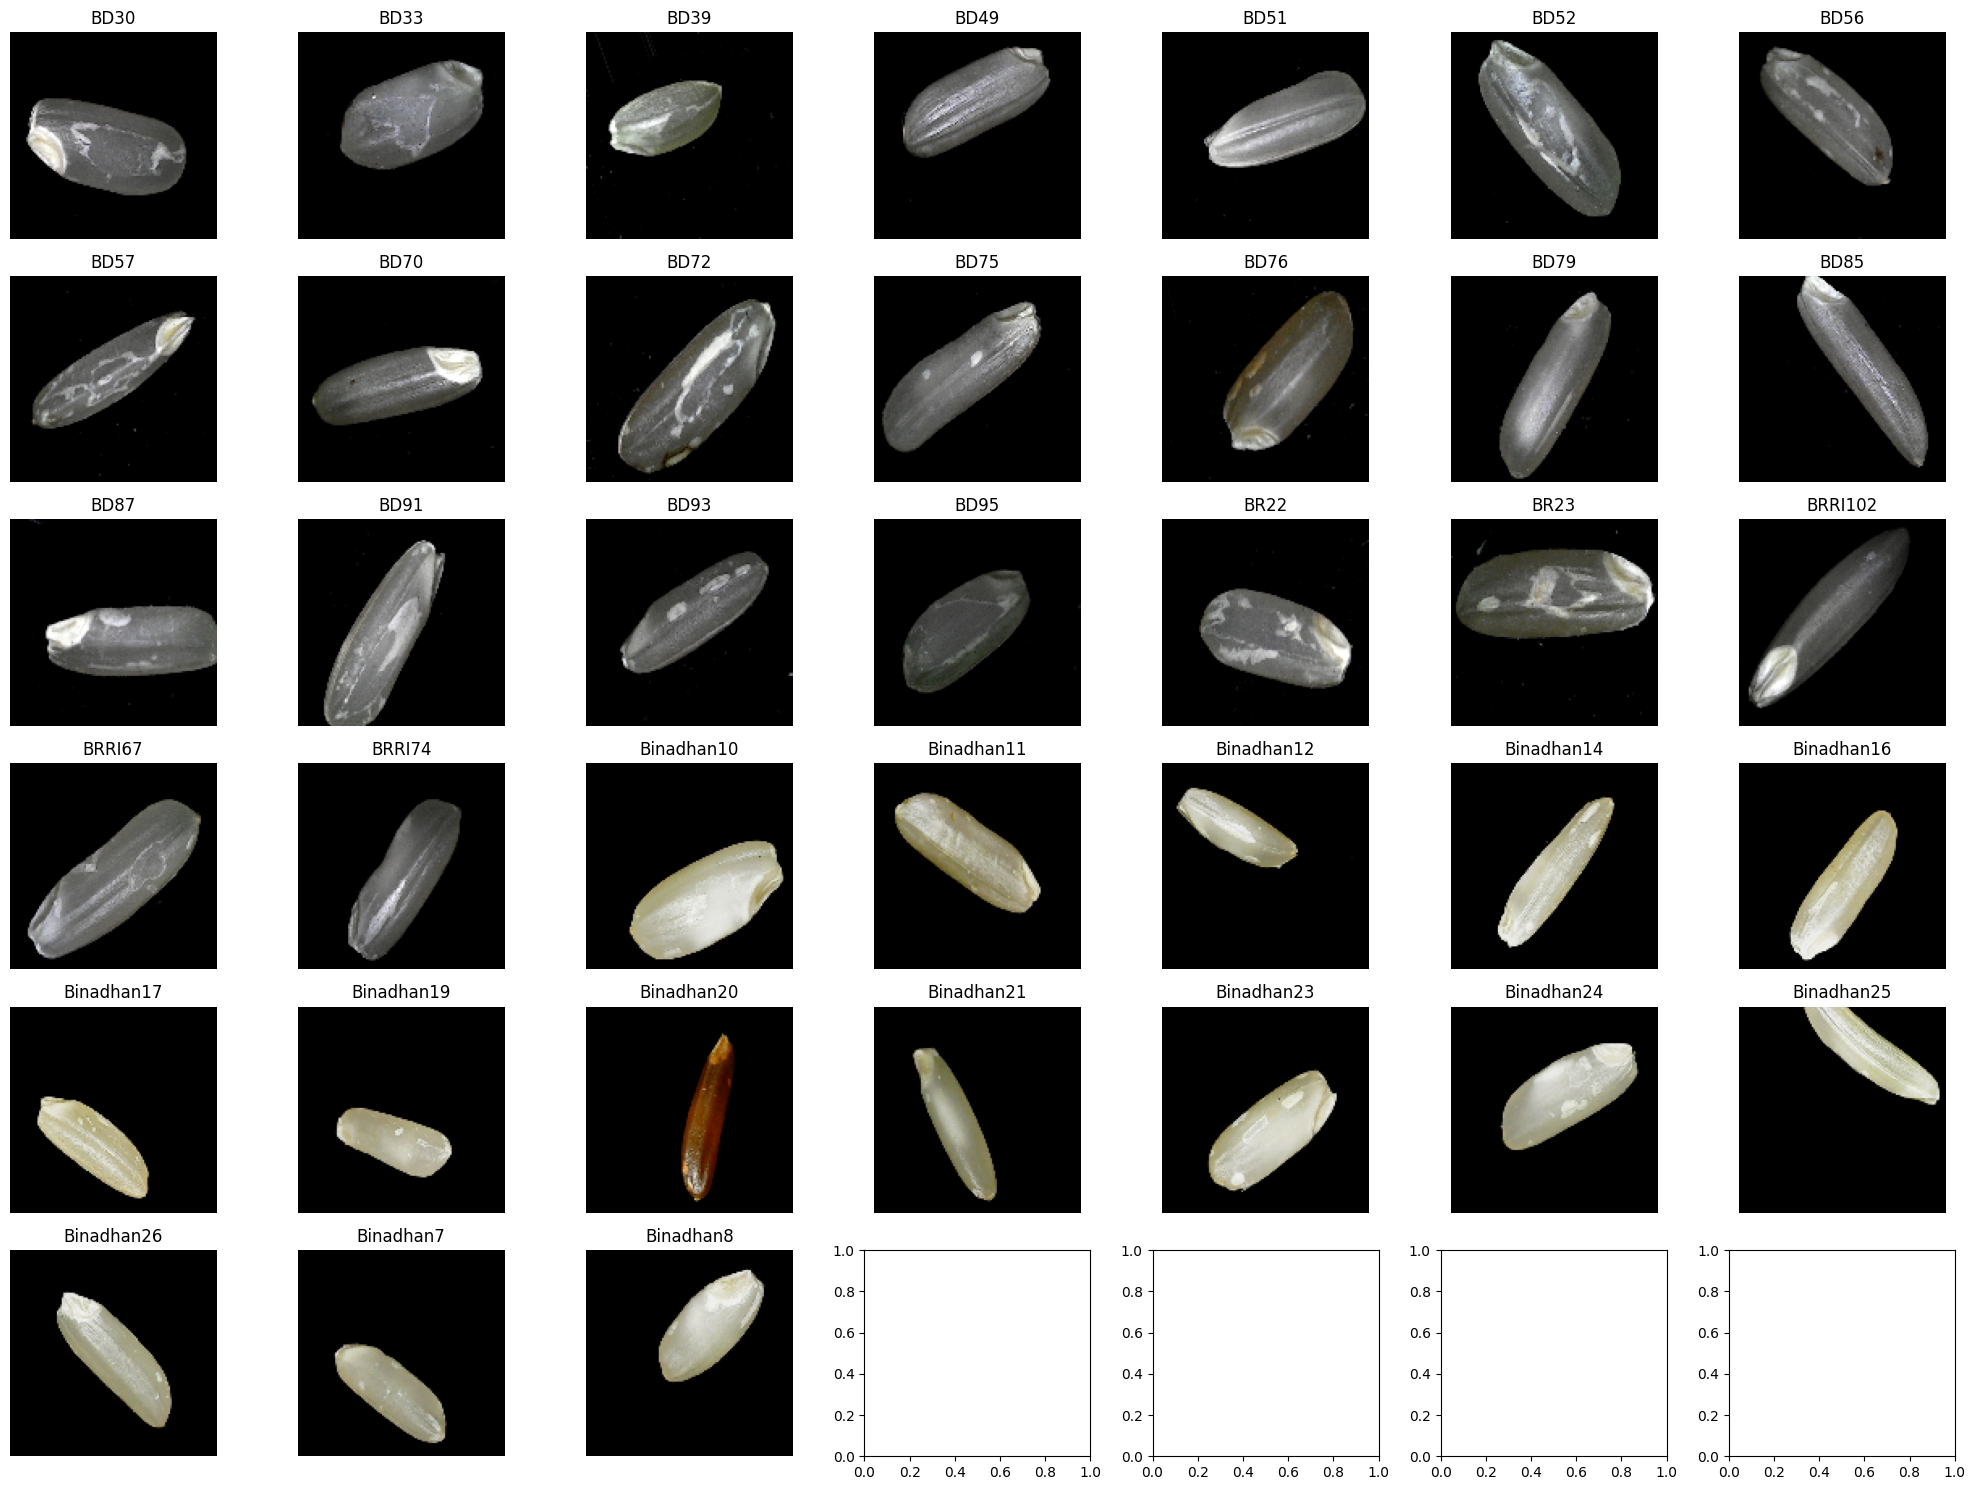

In [6]:
#Show 1 Image per Class (Best Sample from Validation Set)

fig, axes = plt.subplots(6, 7, figsize=(20, 15))
shown = set()

for i, (images, labels) in enumerate(val_generator):
    for img, label in zip(images, labels):
        label_index = np.argmax(label)
        class_name = class_names[label_index]
        if class_name not in shown:
            ax = axes[len(shown)//7, len(shown)%7]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            shown.add(class_name)
            if len(shown) == len(class_names):
                break
    if len(shown) == len(class_names):
        break

plt.tight_layout()
plt.show()


In [7]:
# Build Custom CNN

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753156300.435110      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# Compile the Model

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


**Train the Model**

In [9]:


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120


I0000 00:00:1753156306.593731      76 service.cc:148] XLA service 0x7af13c011bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753156306.594656      76 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753156307.044136      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1900 ━━━━━━━━━━━━━━━━━━━━ 4:16:58 8s/step - accuracy: 0.0000e+00 - loss: 6.3217

I0000 00:00:1753156310.620902      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 497s 257ms/step - accuracy: 0.1311 - loss: 3.3031 - val_accuracy: 0.3102 - val_loss: 2.1234
Epoch 2/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 169s 89ms/step - accuracy: 0.3115 - loss: 2.2155 - val_accuracy: 0.3922 - val_loss: 1.8892
Epoch 3/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 165s 87ms/step - accuracy: 0.4076 - loss: 1.8244 - val_accuracy: 0.2884 - val_loss: 2.6964
Epoch 4/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 161s 85ms/step - accuracy: 0.4720 - loss: 1.5988 - val_accuracy: 0.6164 - val_loss: 1.2378
Epoch 5/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 165s 87ms/step - accuracy: 0.5079 - loss: 1.4567 - val_accuracy: 0.3617 - val_loss: 2.5323
Epoch 6/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 161s 85ms/step - accuracy: 0.5511 - loss: 1.3222 - val_accuracy: 0.4770 - val_loss: 1.9322
Epoch 7/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 156s 82ms/step - accuracy: 0.5765 - loss: 1.2427 - val_accuracy: 0.4853 - val_loss: 1.9515
Epoch 8/120
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 163s 86ms/step - accuracy: 0.6

**Plot Accuracy & Loss**

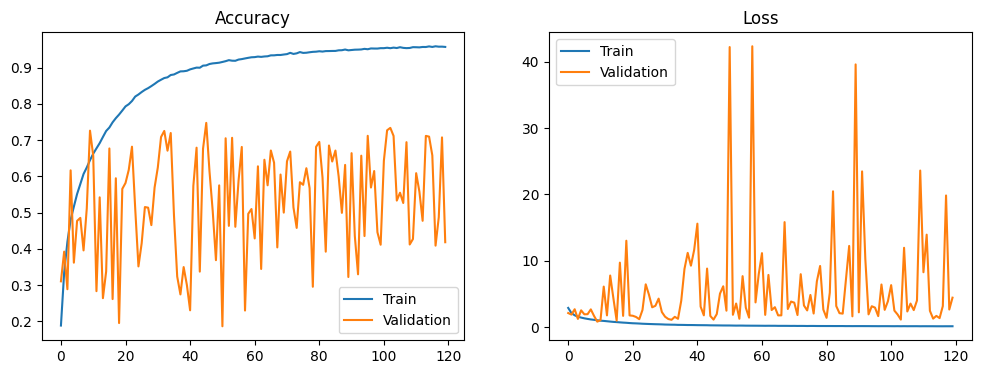

In [10]:


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()


**Classification Report & Confusion Matrix**

475/475 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step


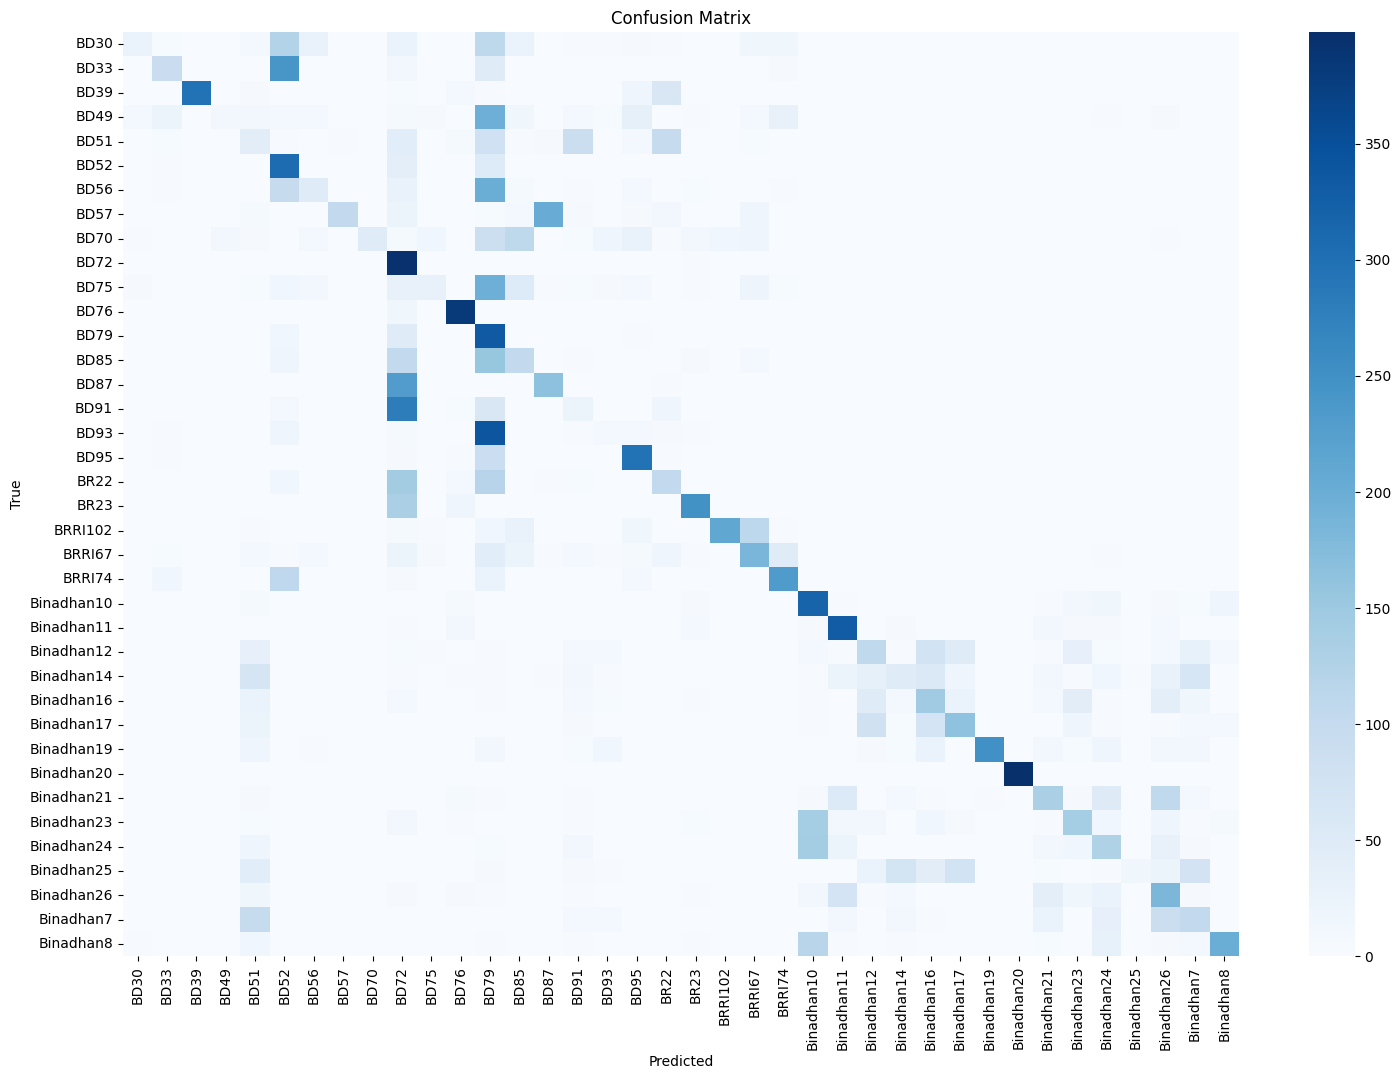

              precision    recall  f1-score   support

        BD30       0.50      0.06      0.11       400
        BD33       0.60      0.23      0.33       400
        BD39       0.99      0.74      0.85       400
        BD49       0.39      0.03      0.05       400
        BD51       0.09      0.11      0.10       400
        BD52       0.31      0.77      0.44       400
        BD56       0.40      0.12      0.18       400
        BD57       0.96      0.26      0.41       400
        BD70       0.92      0.12      0.21       400
        BD72       0.24      0.99      0.38       400
        BD75       0.46      0.07      0.13       400
        BD76       0.81      0.96      0.88       400
        BD79       0.15      0.83      0.26       400
        BD85       0.27      0.26      0.26       400
        BD87       0.43      0.41      0.42       400
        BD91       0.10      0.06      0.07       400
        BD93       0.11      0.03      0.04       400
        BD95       0.63    

In [11]:


Y_true = val_generator.classes
Y_pred_probs = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(Y_true, Y_pred, target_names=class_names))


**A better version:**

475/475 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step


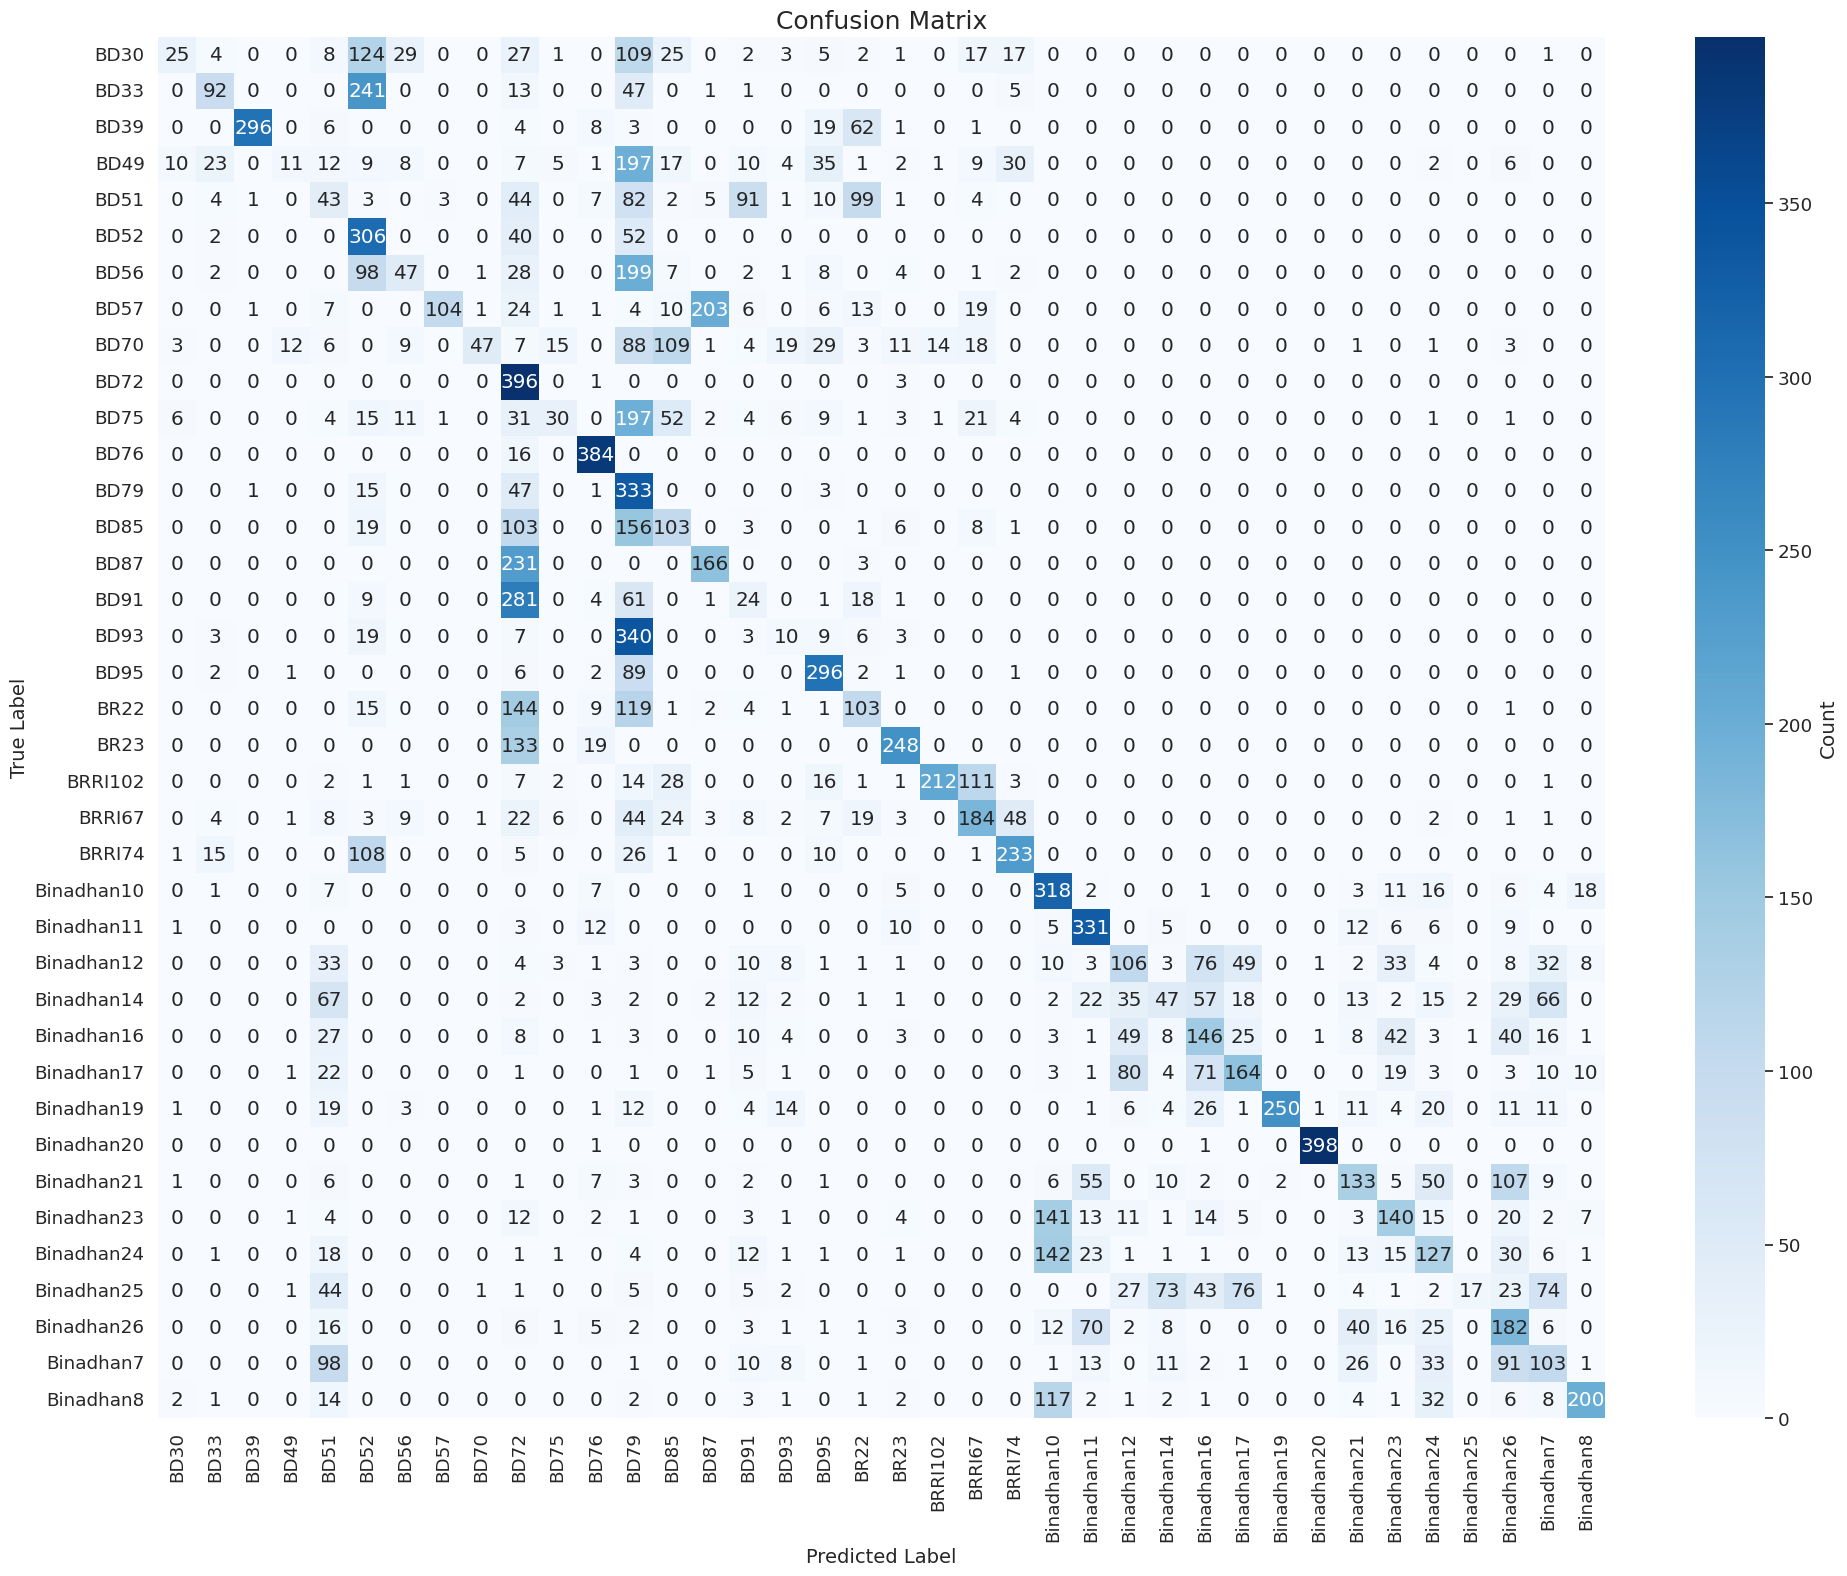

              precision    recall  f1-score   support

        BD30       0.50      0.06      0.11       400
        BD33       0.60      0.23      0.33       400
        BD39       0.99      0.74      0.85       400
        BD49       0.39      0.03      0.05       400
        BD51       0.09      0.11      0.10       400
        BD52       0.31      0.77      0.44       400
        BD56       0.40      0.12      0.18       400
        BD57       0.96      0.26      0.41       400
        BD70       0.92      0.12      0.21       400
        BD72       0.24      0.99      0.38       400
        BD75       0.46      0.07      0.13       400
        BD76       0.81      0.96      0.88       400
        BD79       0.15      0.83      0.26       400
        BD85       0.27      0.26      0.26       400
        BD87       0.43      0.41      0.42       400
        BD91       0.10      0.06      0.07       400
        BD93       0.11      0.03      0.04       400
        BD95       0.63    

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true and predicted labels
Y_true = val_generator.classes
Y_pred_probs = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)

# Plot
plt.figure(figsize=(20, 16))
sns.set(font_scale=1.2)  # Larger font

ax = sns.heatmap(
    cm,
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot=True,        # Add numbers inside cells
    fmt='d',           # Integer format
    cbar_kws={'label': 'Count'}  # Add label to color bar
)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()  # Fit everything nicely
plt.show()

# Print detailed report
print(classification_report(Y_true, Y_pred, target_names=class_names))


In [13]:
from sklearn.metrics import classification_report

report = classification_report(Y_true, Y_pred, target_names=class_names)

# Save to file
with open('classification_report.txt', 'w') as f:
    f.write(report)

print("Classification report saved to classification_report.txt")


Classification report saved to classification_report.txt


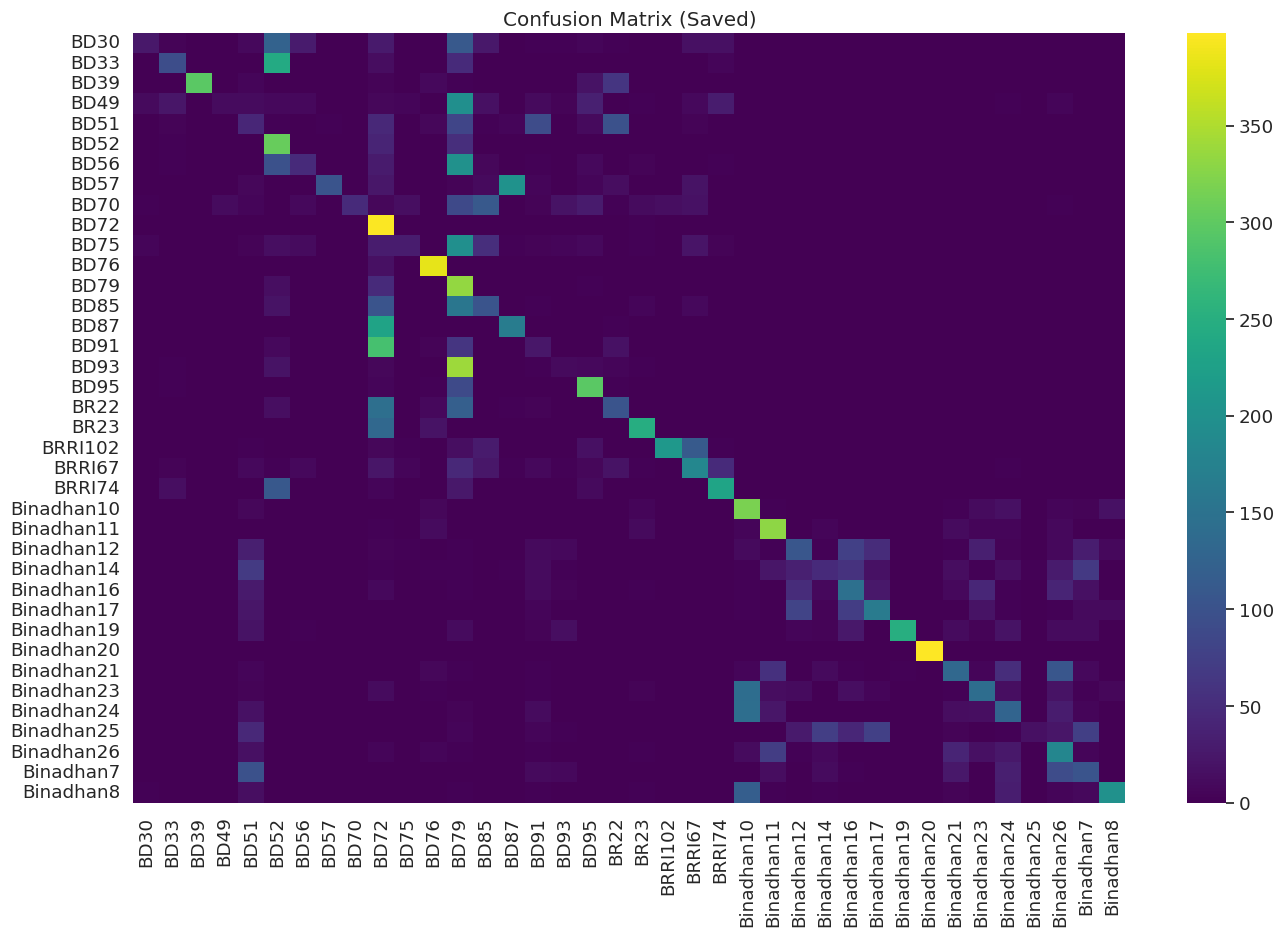

In [14]:
#Save Model and Report Outputs

# Create output directory
os.makedirs('/kaggle/working/rice_model', exist_ok=True)

# Save model
model.save('/kaggle/working/rice_model/custom_rice_model.h5')

# Save classification report
report_text = classification_report(Y_true, Y_pred, target_names=class_names)
with open('/kaggle/working/rice_model/classification_report.txt', 'w') as f:
    f.write(report_text)

# Copy Confusion Matrix as image
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=False, cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Saved)')
plt.savefig('/kaggle/working/rice_model/confusion_matrix.png')


**ROC-AUC Curves:**

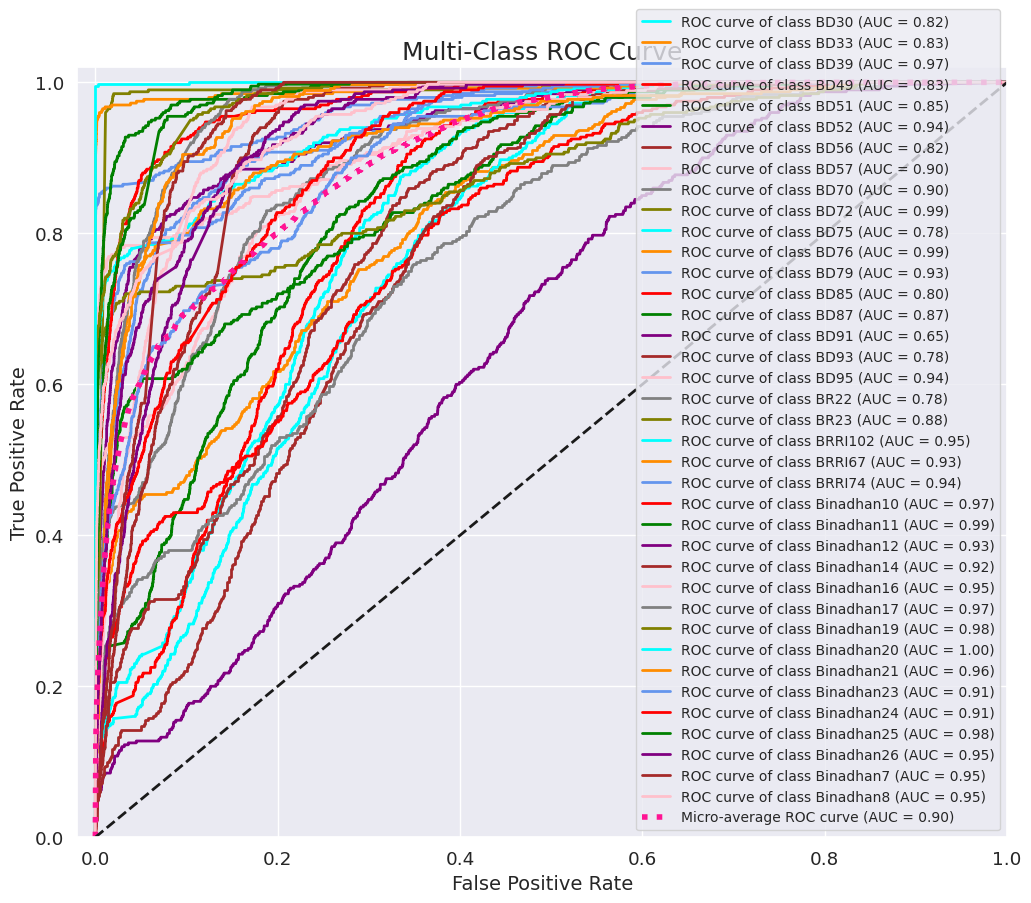

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np



# Binarize true labels for multi-class ROC
Y_true_bin = label_binarize(Y_true, classes=np.arange(len(class_names)))

n_classes = Y_true_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f})'
    )

plt.plot(
    fpr["micro"],
    tpr["micro"],
    color='deeppink',
    linestyle=':',
    linewidth=4,
    label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})'
)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()
